## Signal Processing ENU
August 4, Intern: Diego Varela, Mentor: Surendra Adhikari

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

In [125]:
data_folder = '/Users/diego/Desktop/NASA/SignalProcessing/data/ENU_v2' # path to the folder with the data 
locations = ['AASI', 'ASKY', 'AVAN', 'BLAS', 'DANE', 'DGJG'] # Name of some locations


def get_data(location):
    file_name = str(location) + '.ENU.txt'
    path = os.path.join(data_folder, file_name)

    if os.path.isfile(path):
        data = np.loadtxt(path, skiprows=2)
    else:
        file_name = str(location) + '_ENU.txt'
        path = os.path.join(data_folder, file_name)

        if os.path.isfile(path):
            data = np.loadtxt(path, skiprows=2)
        else:
            raise FileNotFoundError(f"Neither '{location}.ENU.txt' nor '{location}_ENU.txt' found in {data_folder}")
    return data

In [127]:
np.shape(get_data(locations[0]))

(6385, 7)

Data file has shape (features, variables). This is how they look like:
 
 | Time (years) | East (mm) | North (mm) | Up (mm) | East_error (mm) | North_error (mm) | Up_error (mm) |
 | ------------ | --------- | ---------- | ------- | --------------- | ---------------- | --------------|
 | 2005.746739  |  81.1990  | -44.5710   | -22.8590|   0.7640        | 1.0650  |  3.8750 |
 | entry 2 ... |   entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |entry 2 ... |


In [192]:
AASI = get_data('AASI')
AASI_time = AASI[:,0]
AASI_data = AASI[:,1:4]
AASI_error = AASI[:,4:]

AASI_data_detrended = scipy.signal.detrend(AASI_data, axis = 0)

What I am doing with the data:
1. Plots of the Raw Data
2. Detrended data using scipy:  Average is set to zero. 
3. Fast Fourier Transformations: Through frequency, we can observe how often does the signal repeat (i.e. how long are seasons), 
4. PCA: Understand the main drivers of the signal change.

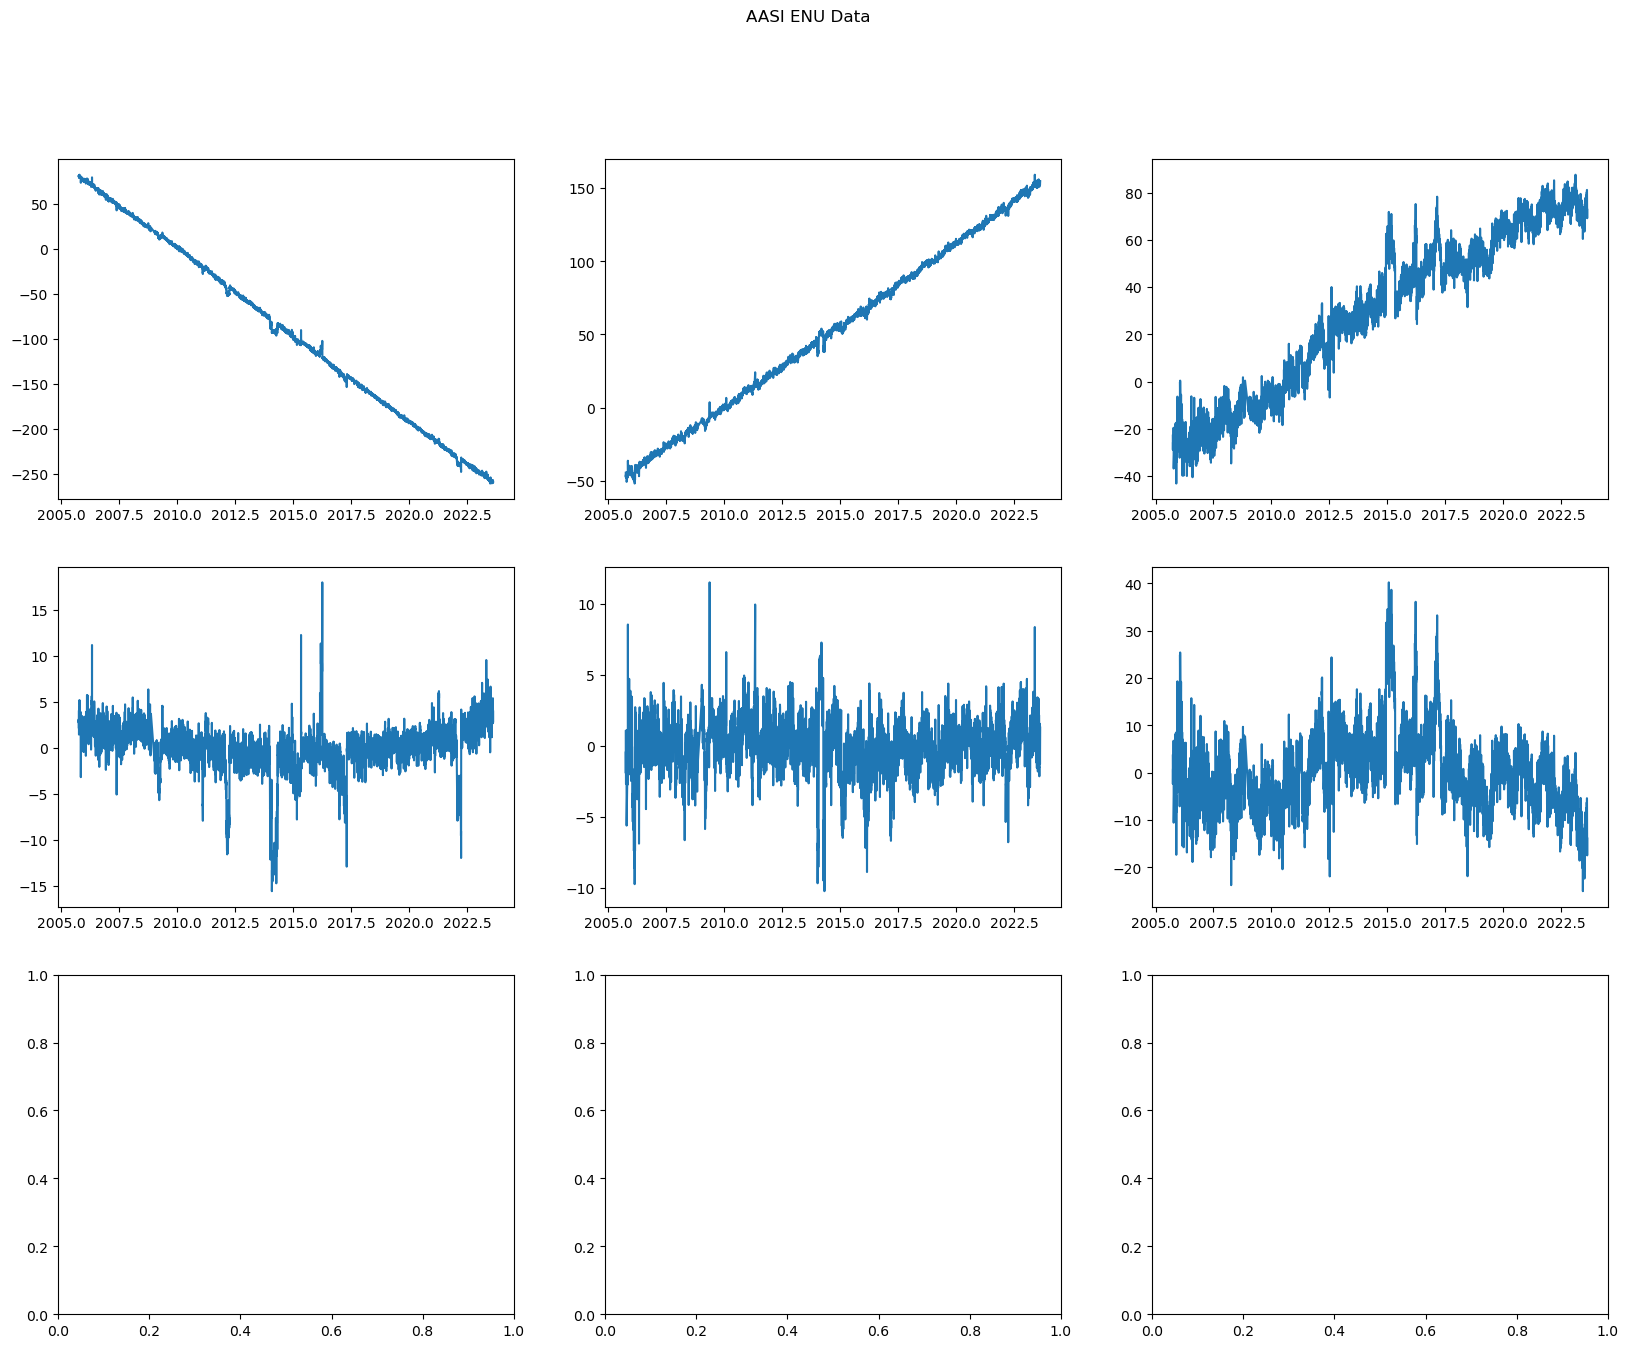

In [198]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
titles = ['East (mm)', 'North (mm)', 'Up (mm)']

axs[0,0].plot(AASI_time, AASI_data[:,0])
axs[0,1].plot(AASI_time, AASI_data[:,1])
axs[0,2].plot(AASI_time, AASI_data[:,2])

axs[1,0].plot(AASI_time, AASI_data_detrended[:,0])
axs[1,1].plot(AASI_time, AASI_data_detrended[:,1])
axs[1,2].plot(AASI_time, AASI_data_detrended[:,2])



fig.suptitle('AASI ENU Data')

plt.show()